In [1]:
import networkx as nx
import pandas
from hatchet import *
import os
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import platform
import json
from ast import literal_eval as make_tuple
import matplotlib.cm as cm
import utils
import mpld3

/home/suraj/miniconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/suraj/miniconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/suraj/miniconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/suraj/miniconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/suraj/miniconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 

In [3]:
# libraries for gromov distance computation.
import numpy as np
import scipy as sp
# import ot
from sklearn.decomposition import PCA
from sklearn import manifold

In [4]:
#from actions.groupBy import groupBy
from state import State
from preprocess import PreProcess

In [5]:
%matplotlib inline

In [8]:
# pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (16, 12)

In [7]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        import numpy as np
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
from mpld3 import _display
_display.NumpyEncoder = NumpyEncoder

# Change the directory name according to your system

In [9]:
dirname = "/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/.callflow"
# dirname = "/Users/padmanabanke1/CallFlow/.callflow"
# dirname = "/home/vidi/Work/llnl/CallFlow/.callflow"

## Load the datasets and create Dataframes

In [10]:
def replace_str_with_Node(df, graph):
        mapper = {}
        def dfs_recurse(root):
            for node in root.children: 
                mapper[node.callpath[-1]] = Node(node.nid, node.callpath, None)
                dfs_recurse(node)
        for root in graph.roots:
            mapper[root.callpath[-1]] = Node(root.nid, root.callpath, None)
            dfs_recurse(root)
        df['node'] = df['node'].apply(lambda node: mapper[node] if node in mapper else '')
        return df

In [11]:
def read_gf(name):
    state = State()
    df_filepath = dirname + '/' + name +  '/filter_df.csv'
    entire_df_filepath = dirname + '/' + name + '/entire_df.csv'
    graph_filepath = dirname + '/' + name + '/filter_graph.json'
    entire_graph_filepath = dirname + '/' + name + '/entire_graph.json'   

    with open(graph_filepath, 'r') as graphFile:
        data = json.load(graphFile)

    state.gf = GraphFrame()
    state.gf.from_literal(data)

    with open(entire_graph_filepath, 'r') as entire_graphFile:
        entire_data = json.load(entire_graphFile)
            
    state.entire_gf = GraphFrame()
    state.entire_gf.from_literal(entire_data)

    state.df = pd.read_csv(df_filepath)
    state.entire_df = pd.read_csv(entire_df_filepath)

    state.graph = state.gf.graph
    state.entire_graph = state.entire_gf.graph

#     state.map = state.node_hash_mapper()

    # Print the module group by information. 
    # print(state.df.groupby(['module']).agg(['mean','count']))

    # replace df['node'] from str to the Node object.
    state.df = replace_str_with_Node(state.df, state.graph)
    state.entire_df = replace_str_with_Node(state.entire_df, state.entire_graph)

    return state

In [12]:
# datasets = ["kripke-mvapich2", "kripke-openmpi"]
datasets = ['calc-pi', 'calc-pi-half','calc-pi-random-1']
states = {}
for idx, dataset_name in enumerate(datasets):
    state = read_gf(dataset_name)
    states[dataset_name] = state
print(states)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/.callflow/calc-pi/filter_graph.json'

# Create networkx graphs.

In [13]:
def lookup_with_name(df, name):
    return df.loc[df['name'] == name]

In [14]:
def add_paths(state, path_name):
    for idx, row in state.df.iterrows():
        if row.show_node:
            path = row[path_name]
            if isinstance(path, str):
                path = make_tuple(row[path_name])
            state.g.add_path(path)   

In [15]:
def generic_map(df, nodes, attr):
    ret = {}
    for node in nodes: 
        if attr == 'time (inc)':
            ret[node] = df[df['name'] == node][attr].mean()
        else:
            ret[node] = df[df['name'] == node][attr].unique().tolist()     
    return ret

In [16]:
def calculate_flows(state):
    graph = state.g
    ret = {}                                                                                                                                                                                                                                                                          
    edges = graph.edges()                                                                                                                                                                                                                                                             
    additional_flow = {}                                                                                                                                                                                                                                                              
                                                                                                                                                                                                                                                                                          
    # Calculates the costs in cycles and aggregates to one node.                                                                                                                                                                                                                      
    for edge in edges:                                                                                                                                                                                                                                                                
        source = edge[0]                                                                                                                                                                                                                                                              
        target = edge[1]                                                                                                                                                                                                                                                              
                                                                                                                                                                                                                
    for edge in edges:                                                                                                                                                                                                                                                                
        added_flow = 0                                                                                                                                                                                                                                                                
        if edge[0].endswith('_'):                                                                                                                                                                                                                                                     
            ret[edge] = additional_flow[edge[0]]                                                                                                                                                                                                                                      
            continue                                                                                                                                                                                                                                                                  
        elif edge[1].endswith('_'):                                                                                                                                                                                                                                                   
            ret[edge] = additional_flow[edge[1]]                                                                                                                                                                                                                                      
            continue                                                                                                                                                                                                                                                                  
        source = lookup_with_name(state.df, edge[0])                                                                                                                                                                                                                         
        target = lookup_with_name(state.df, edge[1])                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                          
        source_inc = source['time (inc)'].max()                                                                                                                                                                                                                               
        target_inc = target['time (inc)'].max()                                                                         
                                                                                                                                                                                                                                                                                          
        if source_inc == target_inc:                                                                                                                                                                                                                                                  
            ret[edge] = source_inc                                                                                                                                                                                                                                                    
        else:                                                                                                                                                                                                                                                                         
            ret[edge] = target_inc    
    return ret   

In [17]:
def add_edge_attributes(state):
    capacity_mapping = calculate_flows(state)    
    nx.set_edge_attributes(state.g, name='weight', values=capacity_mapping)

In [18]:
def add_node_attributes(state):
    module_mapping = generic_map(state.df, state.g.nodes(), 'module')
    nx.set_node_attributes(state.g, name='module', values=module_mapping)
    
    time_mapping = generic_map(state.df, state.g.nodes(), 'time (inc)')
    nx.set_node_attributes(state.g, name='time (inc)', values=time_mapping)

In [19]:
def create_nx_graph(states):
    for idx, state_name in enumerate(states):
        state = states[state_name]
        state.g = nx.DiGraph()
        root_df = lookup_with_name(state.df, state.graph.roots[0].callpath[-1])
        state.root = root_df['name'].tolist()[0]
        state.rootInc = root_df['time (inc)'].max()
        add_paths(state, 'path')
#         state.levelMap = add_levels(state)
        add_node_attributes(state)
        add_edge_attributes(state)  
    return states

In [20]:
states = create_nx_graph(states)
print(states)

{}


## Flow Matrix computation

In [21]:
def create_flow_matrix(state, module):
    g = state.g
    all_nodes = g.nodes(data=True)
#     nod = [(x,y) for x, y in g.nodes(data=True)]
    nodes = [x for x,y in g.nodes(data=True) if y['module'] == [module]]
    print(nodes)
    # nodesInModule = filter(lambda (n, d): d['module'] == start_node, g.nodes(data=True))
    state.nodeKey = {}
    for idx, node in enumerate(nodes):
        state.nodeKey[node[0]] = idx
    
    flow_matrix = np.zeros(shape=(len(nodes),len(nodes)))
    flow_matrix.astype(float)
    root_inc = g.node[nodes[0]]['time (inc)']
    print(root_inc)
#     root_inc = 194595257.0
    
    for idx, node in enumerate(nodes):
        print(g[node].items())
#         neighbors = sorted(g[node].items(), key=lambda edge: edge[0]['weight'])
#         print(neighbors)
        neighbors = sorted(g[node].items(), key=lambda edge: edge[1]['weight'])
        print(neighbors)
        for idx, n in enumerate(neighbors):
            sourceKey = int(state.nodeKey[node])
#            print(state.df[state.df['node' == n[0]]])
            targetKey = int(state.nodeKey[n[0]])
            weight = n[1]['weight']
            flow_matrix[sourceKey][targetKey] = n[1]['weight']/(1.0*root_inc)
    print(flow_matrix)
    return flow_matrix

In [24]:
print(states[datasets[0]].entire_df['module'].unique())
module = 'libmpi.so.12.0.5'
# module = 'Unknown(NA)'
module = 'libmonitor.so.0.0.0'
flow_matrices = []
for idx, state in enumerate(states):
    flow_matrix = create_flow_matrix(states[state], module)
    flow_matrices.append(flow_matrix)
#     plt.matshow(flow_matrix)
fm = np.array([flow_matrices[0], flow_matrices[1]])

KeyError: 'calc-pi'

## Plot histogram

In [23]:
def histogram(variable):
    n_bins = 2
    N, bins, patches = plt.hist(variable, bins=n_bins)
    #fracs = N / N.max()
    #norm = colors.Normalize(fracs.min(), fracs.max())
    #for thisfrac, thispatch in zip(fracs, patches):
    #    color = plt.cm.viridis(norm(thisfrac))
    #    thispatch.set_facecolor(color)
    #plt.yaxis.set_major_formatter(PercentFormatter(xmax=1))

## Calculate Spatial distance between each node in the flow matrix

In [25]:
S = len(states) - 1

n_samples = 40
ns = [len(fm[s]) for s in range(S)]

Cs = [sp.spatial.distance.cdist(fm[s], fm[s]) for s in range(S)]
Cs = [cs / cs.max() for cs in Cs]

ps = [ot.unif(ns[s]) for s in range(S)]
p = ot.unif(n_samples)

histogram(p)

histogram(ns)

NameError: name 'ot' is not defined

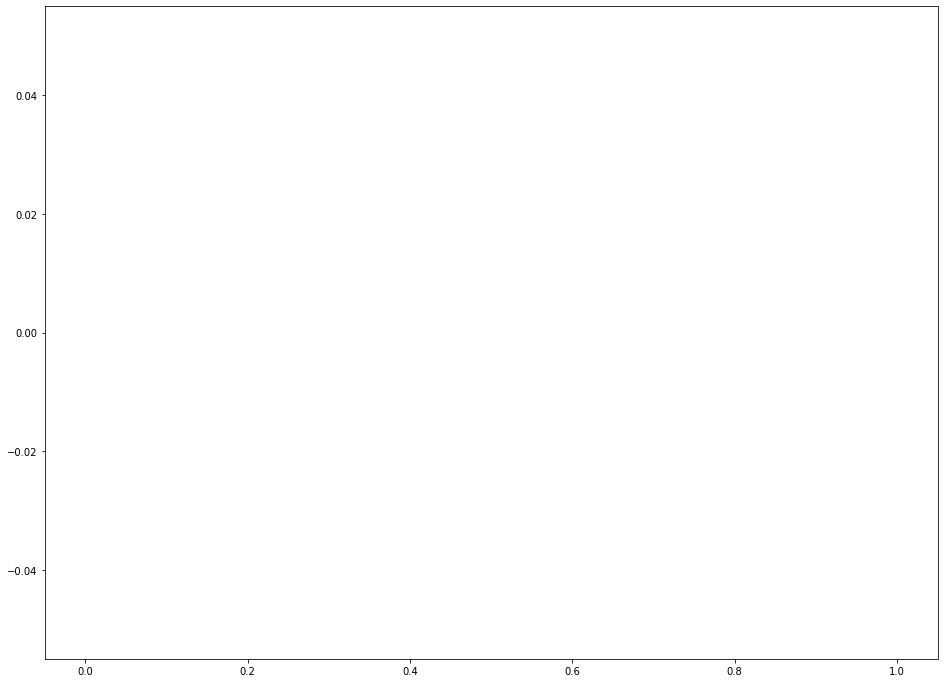

In [26]:
histogram(ps)

## Gromov wassertstein barycenter calculation

By barycenter they mean the design of an “average” or barycenter of similarity matrices.

In [ ]:
def plot(variable):
    fig, ax = plt.subplots()

    plt.plot(variable[0], variable[1], 'o', label=str(variable))
    
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)
    mpld3.show()

In [ ]:
def smacof_mds(C, dim, max_iter=3000, eps=1e-9):
    """
    Returns an interpolated point cloud following the dissimilarity matrix C
    using SMACOF multidimensional scaling (MDS) in specific dimensionned
    target space

    Parameters
    ----------
    C : ndarray, shape (ns, ns)
        dissimilarity matrix
    dim : int
          dimension of the targeted space
    max_iter :  int
        Maximum number of iterations of the SMACOF algorithm for a single run
    eps : float
        relative tolerance w.r.t stress to declare converge

    Returns
    -------
    npos : ndarray, shape (R, dim)
           Embedded coordinates of the interpolated point cloud (defined with
           one isometry)
    """

    rng = np.random.RandomState(seed=3)

    mds = manifold.MDS(
        dim,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity='precomputed',
        
        n_init=1)
    pos = mds.fit(C).embedding_

    nmds = manifold.MDS(
        2,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=rng,
        n_init=1)
    npos = nmds.fit_transform(C, init=pos)

    return npos

In [ ]:
lambdast = [[float(i) / 3, float(3 - i) / 3] for i in [1, 2]]
Ct01 = [0 for i in range(2)]
for i in range(S):
    Ct01[i] = ot.gromov.gromov_barycenters(n_samples, [Cs[0], Cs[1]],
                                           [ps[0], ps[1]
                                            ], p, lambdast[i], 'square_loss',  # 5e-4,
                                           max_iter=100, tol=1e-9)

In [ ]:
clf = PCA(n_components=2)
npos = [0, 0]
npos = [smacof_mds(Cs[s], 2) for s in range(S)]

npost01 = [0, 0]
npost01 = [smacof_mds(Ct01[s], 2) for s in range(2)]
npost01 = [clf.fit_transform(npost01[s]) for s in range(2)] 

In [ ]:
print(len(Ct01[0]))

In [ ]:
plot(Ct01)

In [ ]:
plot(npost01)

In [ ]:
nx01min = npos[0][0][0]
nx01max = npos[0][0][0]
ny01min = npos[0][1][1]
ny01max = npos[0][1][1]

nx02min = npos[1][0][0]
nx02max = npos[1][0][0]
ny02min = npos[1][1][1]
ny02max = npos[1][1][1]

for idx, arr in enumerate(npos):
    if arr[0][0] < nx01min:
        nx01min = arr[0][0]
    else:
        pass
    
    if arr[0][1] > nx01max:
        nx01max = arr[0][1]
    else:
        pass
    
    if arr[1][0] < ny01min:
        ny01min = arr[1][0]
    else:
        pass
    
    if arr[1][1] > ny01max:
        ny01max = arr[1][1]
    else:
        pass


for idx, arr in enumerate(npost01):
    if arr[0][0] < nx02min:
        nx02min = arr[0][0]
    else:
        pass
    
    if arr[0][1] > nx02max:
        nx02max = arr[0][1]
    else:
        pass
    
    if arr[1][0] < ny02min:
        ny02min = arr[1][0]
    else:
        pass
    
    if arr[1][1] > ny02max:
        ny02max = arr[1][1]
    else:
        pass

fig = plt.figure(figsize=(10, 10))

x1 = []
y1 = []
for idx, val in enumerate(npost01[0]):
    x1.append(val[0])
    y1.append(val[1])
    
x2 = []
y2 = []
for idx, val in enumerate(npost01[1]):
    x2.append(val[0])
    y2.append(val[1])

x1 = np.asarray(x1)
x2 = np.asarray(x2)
y1 = np.asarray(y1)
y2 = np.asarray(y2)

fig, ax = plt.subplots()

scatter = plt.scatter(x1, y1, color='b')
scatter = plt.scatter(x2, y2, color='r')

ax.grid(color='#aaaaaa', linestyle='solid')
ax.set_title("Gromov wasserstein barycenter", size=20)
        
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.show()

In [ ]:
def draw_graph(state, module):
    g = state.g
    hierarchy = nx.Graph()
    source_target_data = []
    nodes = [x for x,y in g.nodes(data=True) if y['module'] == [module]]
    node = nodes[0]
    for idx, node in enumerate(nodes):
        hierarchy_pd = pd.DataFrame(columns=['source', 'target', 'weight', 'level', 'type'])
        neighbors = sorted(g[node].items(), key=lambda edge: edge[1]['weight'])
        for idx, n in enumerate(neighbors):
            #print("source: {0}, target: {1}".format(node, n[0]))
            source_node = node
            target_node = n[0]
            weight = n[1]['weight']
            level = idx
            if(state.df[state.df['name'] == n[0]]['module'].unique()[0] != module):
                type_node = 'exit'
                level = -1
                print('{0} is an exit node'.format(n[0]))
            else:
                type_node = 'normal'
            source_target_data.append({
                "source": source_node,
                "target": target_node,
                "weight": weight,
                "level": level,
                "type": type_node
            })
    hierarchy_df = pd.DataFrame.from_dict(source_target_data)
    print(hierarchy_df.shape)
    hierarchy_adjacency = source_target_to_adj_matrix(source_target_data)
    state.hg = nx.from_numpy_matrix(hierarchy_adjacency)
    pos = hierarchy_pos(state.hg, 1)
    nx.draw(state.hg, pos=pos, with_labels=True)
    plt.show()

draw_graph(states[0], 'lulesh2.0')

In [ ]:
def get_adjcency(nodelist):
    x_pd = nx.to_pandas_adjacency(g, nodelist=nodes, dtype=int)   

In [ ]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    #if not nx.is_tree(G):
     #   raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
        print(root)
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)